In [321]:
import pandas as pd
import seaborn as  sns
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
import numpy as np
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from operator import attrgetter

In [2]:
warnings.filterwarnings('ignore')

In [3]:
sns.set(rc={'figure.figsize':(16,9)})

## Данные 

### customers :

•customer_id — позаказный идентификатор пользователя

•customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

•customer_zip_code_prefix —  почтовый индекс пользователя

•customer_city —  город доставки пользователя

•customer_state —  штат доставки пользователя

### orders :

•order_id —  уникальный идентификатор заказа (номер чека)

•customer_id —  позаказный идентификатор пользователя

•order_status —  статус заказа

•order_purchase_timestamp —  время создания заказа

•order_approved_at —  время подтверждения оплаты заказа

•order_delivered_carrier_date —  время передачи заказа в логистическую службу

•order_delivered_customer_date —  время доставки заказа

•order_estimated_delivery_date —  обещанная дата доставки

### items :

•order_id —  уникальный идентификатор заказа (номер чека)

•order_item_id —  идентификатор товара внутри одного заказа

•product_id —  ид товара (аналог штрихкода)

•seller_id — ид производителя товара

•shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

•price —  цена за единицу товара

•freight_value —  вес товара

"Подтянем" наши данные. Посмотрим на пропущенные значения и т.д.

In [4]:
path_customers = 'olist_customers_dataset.csv'
path_orders = 'olist_orders_dataset.csv'
path_items = 'olist_order_items_dataset.csv'

In [5]:
customers = pd.read_csv(path_customers)
items = pd.read_csv(path_items, parse_dates=['shipping_limit_date'])
orders = pd.read_csv(path_orders, parse_dates=['order_purchase_timestamp',
                                               'order_approved_at',
                                               'order_delivered_carrier_date',
                                               'order_delivered_customer_date',
                                               'order_estimated_delivery_date'])

In [6]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [8]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [9]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [10]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [12]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [13]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [14]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [15]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [16]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Видимо не все товары дошли 

In [17]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [18]:
orders \
    .groupby(['order_status']) \
    .agg({
    'order_purchase_timestamp':'count',
    'order_approved_at':'count',
    'order_delivered_carrier_date':'count',
    'order_delivered_customer_date':'count',
    'order_estimated_delivery_date':'count'
})

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_status,,,,,
approved,2,2,0,0,2
canceled,625,484,75,6,625
created,5,0,0,0,5
delivered,96478,96464,96476,96470,96478
invoiced,314,314,0,0,314
processing,301,301,0,0,301
shipped,1107,1107,1107,0,1107
unavailable,609,609,0,0,609


Как мы можем видеть, заказ может быть отменен на все стадиях, поэтому 'canceled' мы не включаем в определение покупки

Также мы не включаем 'created' и 'unavailable'.

После того как заказ создан('created'), нужно чтобы его как минимум подтвердили, т.е. товар есть на складе и т.д.

'unavailable' - я так понимаю произошла ошибка, соответсвенно деньги мы вернем, пользователь покупку не совершил. В чем разница между 'unavailable' и 'canceled'? Может быть в том, что отменен может быть на любой стадии(также по инициативе покупателя), а вот статус 'недоступен' заказ получает при 1-ой проверке(т.е. все есть, доставить сможем и т.д.). Это лишь мои догадки, но думаю, что однозначно брать эти статусы в определение покупки не стоит.

Вынесем отдельно данные без вышеупомянутых статусов 

In [19]:
minus = ['unavailable', 'canceled', 'created']

In [20]:
purchase = orders.query("order_status not in @minus")
purchase

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


## Задание 1

### Сколько у нас пользователей, которые совершили покупку только один раз?

Объединим данные, затем сгруппируем по id, посчитаем кол-во заказов.

In [21]:
only_1_order = purchase.merge(customers, on='customer_id', how='inner') \
    .groupby(['customer_unique_id']) \
    .agg({'order_id' : 'count'}) \
    .rename(columns={'order_id':'count_orders'}) \
    .query("count_orders == 1") \
    .shape[0]
only_1_order

92099

In [22]:
all_orders = purchase.shape[0]
all_orders

98202

In [344]:
str(round((only_1_order / all_orders) * 100, 2) ) + ' %'

'93.79 %'

93.97% - на мой взгляд это много => вероятно у нас магазин/услуги, в которых многократно мало кто нуждается 

## Задание 2

### Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Не совсем понятно, что имеется ввиду под "причиной". Но я так думаю, это наши 'unavailable' и 'canceled'.

In [25]:
orders.query("order_status in ['unavailable', 'canceled']") \
    .groupby(['order_status']) \
    .agg({
    'order_approved_at' : 'count',
    'order_delivered_carrier_date':'count',
    'order_delivered_customer_date':'count'
})

,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
order_status,,,
canceled,484,75,6
unavailable,609,0,0


In [26]:
orders['year'] = orders.order_purchase_timestamp.dt.year
orders['month'] = orders.order_purchase_timestamp.dt.month
orders['date'] = orders.order_purchase_timestamp.dt.date
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year,month,date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,2018-02-13


In [27]:
cancellation_reasons_per_date = orders.query("order_status in ['unavailable', 'canceled']") \
    .groupby(['order_status','date']) \
    .agg({'order_id':'count'}) \
    .reset_index() \
    .pivot(columns='order_status', index='date') \
    .resample('M')\
    .sum() 

In [28]:
cancellation_reasons_per_date

order_id            
order_status canceled unavailable
date                             
2016-09-30        2.0         0.0
2016-10-31       24.0         7.0
2016-11-30        0.0         0.0
2016-12-31        0.0         0.0
2017-01-31        3.0        10.0
2017-02-28       17.0        45.0
2017-03-31       33.0        32.0
2017-04-30       18.0         9.0
2017-05-31       29.0        31.0
2017-06-30       16.0        24.0
2017-07-31       28.0        52.0
2017-08-31       27.0        32.0
2017-09-30       20.0        38.0
2017-10-31       26.0        58.0
2017-11-30       37.0        84.0
2017-12-31       11.0        42.0
2018-01-31       34.0        48.0
2018-02-28       73.0        30.0
2018-03-31       26.0        17.0
2018-04-30       15.0         5.0
2018-05-31       24.0        16.0
2018-06-30       18.0         4.0
2018-07-31       41.0        18.0
2018-08-31       84.0         7.0
2018-09-30       15.0         0.0
2018-10-31        4.0         0.0

In [29]:
cancellation_reasons_per_date=cancellation_reasons_per_date.order_id

In [30]:
cancellation_reasons_per_date['total']=cancellation_reasons_per_date['canceled'] + cancellation_reasons_per_date['unavailable']

In [32]:
cancellation_reasons_per_date

order_status,canceled,unavailable,total
date,,,
2016-09-30,2.0,0.0,2.0
2016-10-31,24.0,7.0,31.0
2016-11-30,0.0,0.0,0.0
2016-12-31,0.0,0.0,0.0
2017-01-31,3.0,10.0,13.0
2017-02-28,17.0,45.0,62.0
2017-03-31,33.0,32.0,65.0
2017-04-30,18.0,9.0,27.0
2017-05-31,29.0,31.0,60.0


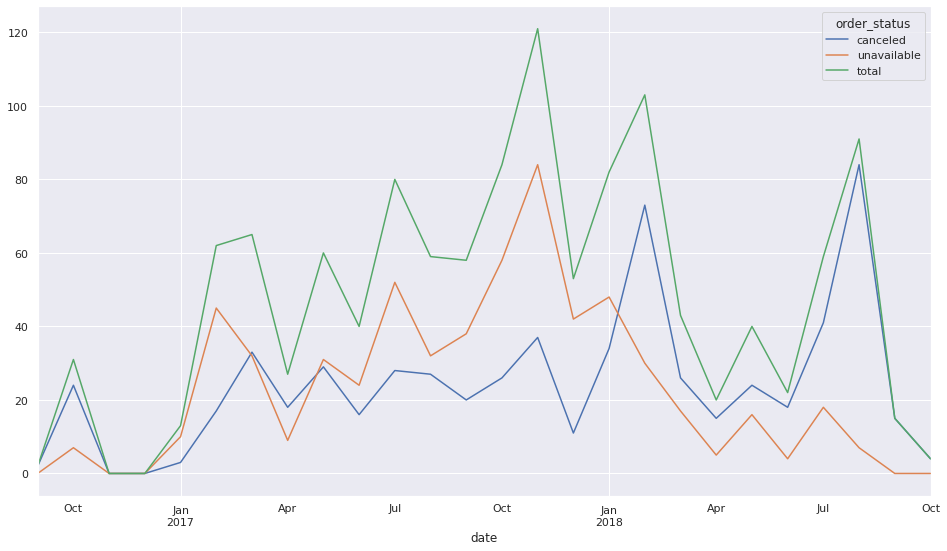

In [31]:
cancellation_reasons_per_date.plot();

Временной ряд нам показывает сколько в среднем отменяли заказ

## Задание 3

### По каждому товару определить, в какой день недели товар чаще всего покупается.

In [33]:
purchase['date'] = purchase.order_purchase_timestamp.dt.date

In [34]:
purchase['day_of_week'] = purchase.date.apply(pd.to_datetime).dt.day_name()
purchase

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-02,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07-24,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08-08,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11-18,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02-13,Tuesday
...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017-03-09,Thursday
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2018-02-06,Tuesday
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,2017-08-27,Sunday
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2018-01-08,Monday


In [35]:
product_mode_day = purchase.merge(items, how='inner', on='order_id') \
    .groupby(['product_id']) \
    .day_of_week.apply(lambda x: x.mode()) \
    .to_frame() \
    .rename(columns={'day_of_week':'mode_day'})

In [36]:
product_mode_day = product_mode_day \
    .groupby(['product_id']) \
    .mode_day.apply(list).to_frame() 

In [37]:
product_mode_day.reset_index()

,product_id,mode_day
0,00066f42aeeb9f3007548bb9d3f33c38,[Sunday]
1,00088930e925c41fd95ebfe695fd2655,[Tuesday]
2,0009406fd7479715e4bef61dd91f2462,[Thursday]
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,[Tuesday]
...,...,...
32724,fff6177642830a9a94a0f2cba5e476d1,"[Saturday, Sunday]"
32725,fff81cc3158d2725c0655ab9ba0f712c,[Monday]
32726,fff9553ac224cec9d15d49f5a263411f,[Friday]
32727,fffdb2d0ec8d6a61f0a0a0db3f25b441,[Tuesday]


## Задание 4

### Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [38]:
purchase = orders.query("order_status not in @minus")
purchase['day_in_month']=purchase.date.apply(pd.to_datetime).dt.daysinmonth

In [39]:
purchase_customers = purchase.merge(customers, how='inner', on='customer_id')[['customer_unique_id',
                                                          'customer_id',
                                                          'order_purchase_timestamp',
                                                          'date',
                                                          'day_in_month']]
purchase_customers['week_in_month'] = purchase_customers['day_in_month'] / 7
purchase_customers['year-month'] = purchase_customers.date.apply(pd.to_datetime).dt.to_period('M')

In [40]:
purchase_customers

,customer_unique_id,customer_id,order_purchase_timestamp,date,day_in_month,week_in_month,year-month
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02,31,4.428571,2017-10
1,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-24,31,4.428571,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08,31,4.428571,2018-08
3,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18,30,4.285714,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13,28,4.000000,2018-02
...,...,...,...,...,...,...,...
98197,6359f309b166b0196dbf7ad2ac62bb5a,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,2017-03-09,31,4.428571,2017-03
98198,da62f9e57a76d978d02ab5362c509660,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018-02-06,28,4.000000,2018-02
98199,737520a9aad80b3fbbdad19b66b37b30,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017-08-27,31,4.428571,2017-08
98200,5097a5312c8b157bb7be58ae360ef43c,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018-01-08,31,4.428571,2018-01


In [41]:
purchase_customers = purchase_customers \
    .groupby(['customer_unique_id','year-month'], as_index=False)\
    .agg({'customer_id':'count', 'week_in_month':'mean'}) 
purchase_customers

,customer_unique_id,year-month,customer_id,week_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714
...,...,...,...,...
96859,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1,4.285714
96860,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1,4.428571
96861,ffff371b4d645b6ecea244b27531430a,2017-02,1,4.000000
96862,ffff5962728ec6157033ef9805bacc48,2018-05,1,4.428571


In [42]:
purchase_customers['avg_per_week'] = purchase_customers.customer_id / purchase_customers.week_in_month
purchase_customers.sort_values(['customer_unique_id','avg_per_week'], ascending=False)

,customer_unique_id,year-month,customer_id,week_in_month,avg_per_week
96863,ffffd2657e2aad2907e67c3e9daecbeb,2017-05,1,4.428571,0.225806
96862,ffff5962728ec6157033ef9805bacc48,2018-05,1,4.428571,0.225806
96861,ffff371b4d645b6ecea244b27531430a,2017-02,1,4.000000,0.250000
96860,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1,4.428571,0.225806
96859,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1,4.285714,0.233333
...,...,...,...,...,...
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714,0.233333
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571,0.225806


## Задание 5

### Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Как я понял, нужен полный год, поэтому взял 2017, т.к. он последний 

In [295]:
purchase_customers = purchase.query("year == 2017") \
            .merge(customers, how='inner', on='customer_id')

In [296]:
purchase_customers

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year,month,date,day_in_month,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2017-10-02,31,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,2017-11-18,30,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
2,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,2017,7,2017-07-09,31,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR
3,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017,4,2017-04-11,30,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS
4,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,2017,5,2017-05-16,31,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44370,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,2017,10,2017-10-04,31,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT
44371,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,2017,1,2017-01-27,31,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG
44372,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,2017,2,2017-02-23,28,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP
44373,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017,3,2017-03-09,31,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP


In [307]:
purchase_customers_retantion = purchase_customers[['customer_unique_id', 'order_id', 'order_purchase_timestamp']]

In [308]:
purchase_customers_retantion['order_month'] = purchase_customers_retantion.order_purchase_timestamp.dt.to_period('M')

In [309]:
purchase_customers_retantion

,customer_unique_id,order_id,order_purchase_timestamp,order_month
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10
1,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11
2,80bb27c7c16e8f973207a5086ab329e2,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 21:57:05,2017-07
3,36edbb3fb164b1f16485364b6fb04c73,136cce7faa42fdb2cefd53fdc79a6098,2017-04-11 12:22:08,2017-04
4,932afa1e708222e5821dac9cd5db4cae,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,2017-05
...,...,...,...,...
44370,c716cf2b5b86fb24257cffe9e7969df8,9115830be804184b91f5c00f6f49f92d,2017-10-04 19:57:37,2017-10
44371,e03dbdf5e56c96b106d8115ac336f47f,aa04ef5214580b06b10e2a378300db44,2017-01-27 00:30:03,2017-01
44372,831ce3f1bacbd424fc4e38fbd4d66d29,880675dff2150932f1601e1c07eadeeb,2017-02-23 09:05:12,2017-02
44373,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,2017-03


In [310]:
purchase_customers_retantion['cohort'] = purchase_customers_retantion.groupby(['customer_unique_id'])['order_purchase_timestamp'].transform('min').dt.to_period('M')

In [311]:
purchase_customers_retantion

,customer_unique_id,order_id,order_purchase_timestamp,order_month,cohort
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10,2017-09
1,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11,2017-11
2,80bb27c7c16e8f973207a5086ab329e2,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 21:57:05,2017-07,2017-07
3,36edbb3fb164b1f16485364b6fb04c73,136cce7faa42fdb2cefd53fdc79a6098,2017-04-11 12:22:08,2017-04,2017-04
4,932afa1e708222e5821dac9cd5db4cae,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,2017-05,2017-05
...,...,...,...,...,...
44370,c716cf2b5b86fb24257cffe9e7969df8,9115830be804184b91f5c00f6f49f92d,2017-10-04 19:57:37,2017-10,2017-10
44371,e03dbdf5e56c96b106d8115ac336f47f,aa04ef5214580b06b10e2a378300db44,2017-01-27 00:30:03,2017-01,2017-01
44372,831ce3f1bacbd424fc4e38fbd4d66d29,880675dff2150932f1601e1c07eadeeb,2017-02-23 09:05:12,2017-02,2017-02
44373,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,2017-03,2017-03


Сделаем новый датафрейм

In [314]:
cohorts = purchase_customers_retantion.groupby(['cohort', 'order_month']) \
              .agg({'customer_unique_id': 'nunique'})\
                .reset_index()\
                .rename(columns={'customer_unique_id':'count_order'})

In [315]:
cohorts

,cohort,order_month,count_order
0,2017-01,2017-01,753
1,2017-01,2017-02,3
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3
...,...,...,...
72,2017-10,2017-11,31
73,2017-10,2017-12,11
74,2017-11,2017-11,7189
75,2017-11,2017-12,40


In [323]:
cohorts['delta_month'] = (cohorts['order_month'] - cohorts['cohort']).apply(attrgetter('n'))

In [324]:
cohorts

,cohort,order_month,count_order,delta_month
0,2017-01,2017-01,753,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
...,...,...,...,...
72,2017-10,2017-11,31,1
73,2017-10,2017-12,11,2
74,2017-11,2017-11,7189,0
75,2017-11,2017-12,40,1


In [325]:
cohort_pivot = cohorts.pivot_table\
                        (index='cohort', \
                        columns='delta_month', \
                        values='count_order')
cohort_pivot

delta_month,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,753.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
2017-02,1690.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,NaN
2017-03,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
2017-04,2326.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
2017-05,3541.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN,NaN
2017-06,3102.0,14.0,11.0,12.0,8.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07,3823.0,20.0,13.0,9.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4130.0,28.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4076.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [328]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

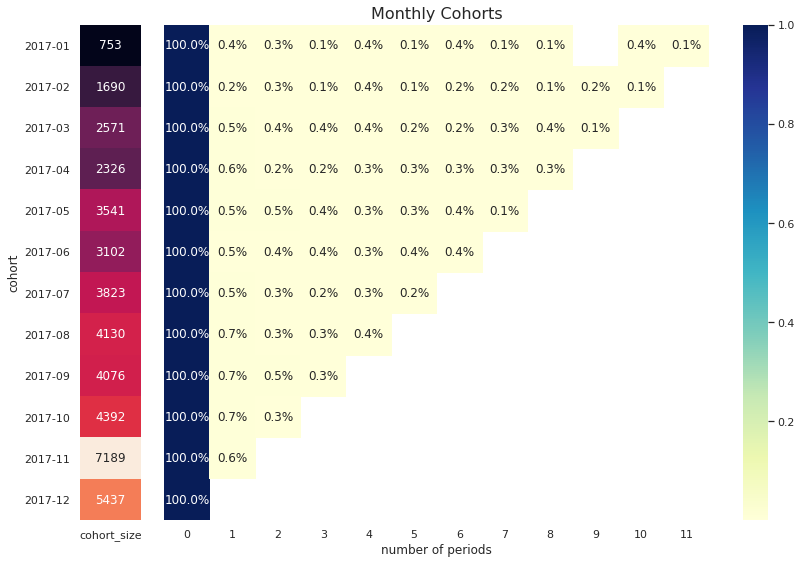

In [342]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.1%', 
                cmap='YlGnBu', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts', fontsize=16)
    ax[1].set(xlabel='number of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                ax=ax[0])

    fig.tight_layout()

## Задание 6

### Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

До этого я уже делал RFM анализ, постраюсь реализваоть 2 метода :

1) Квантильный RFM анализ 

2) С помощью K-Means

Отбрем данные, где заказ дошел до покупателя. Объединим все датафреймы.

In [43]:
full_data = purchase \
            .merge(customers, how='inner', on='customer_id')\
            .merge(items, how='inner', on='order_id')
full_data = full_data.query("order_delivered_customer_date != 'NaT'")
full_data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year,month,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,...,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,...,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,...,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,...,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,...,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112096,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2018,2,...,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112097,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,2017,8,...,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112098,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2018,1,...,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112099,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2018,1,...,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


### Сформируем датафрейм для RFM-анализа :
•customer_unique_id - id покупателя

•Recency - насколько недавно была совершена последняя покупка клиента

•Frequency - как часто клиент совершает покупку

•Monetory -  сколько денег тратит клиент

In [176]:
data = full_data \
    .groupby(['customer_unique_id', 'date'], as_index=False) \
    .agg({'date':'max', 'price':'sum', 'order_id':'count'}) \
    .rename(columns={'price': 'Monetory', 'order_id':'Frequency'})
data

,customer_unique_id,date,Monetory,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,18.90,1
2,0000f46a3911fa3c0805444483337064,2017-03-10,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,180.00,1
...,...,...,...,...
95575,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,1570.00,2
95576,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,64.89,1
95577,ffff371b4d645b6ecea244b27531430a,2017-02-07,89.90,1
95578,ffff5962728ec6157033ef9805bacc48,2018-05-02,115.00,1


In [177]:
data['date'] = pd.to_datetime(data['date'])

In [178]:
print('Orders from {} to {}'.format(data['date'].min(), data['date'].max()))

Orders from 2016-09-15 00:00:00 to 2018-08-29 00:00:00


In [179]:
data.dtypes

customer_unique_id            object
date                  datetime64[ns]
Monetory                     float64
Frequency                      int64
dtype: object

In [180]:
data

,customer_unique_id,date,Monetory,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,18.90,1
2,0000f46a3911fa3c0805444483337064,2017-03-10,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,180.00,1
...,...,...,...,...
95575,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,1570.00,2
95576,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,64.89,1
95577,ffff371b4d645b6ecea244b27531430a,2017-02-07,89.90,1
95578,ffff5962728ec6157033ef9805bacc48,2018-05-02,115.00,1


In [181]:
NOW = data['date'].max() + timedelta(days=1)
NOW

Timestamp('2018-08-30 00:00:00')

Оставим данные только за последний год

In [182]:
data['Recency']=data['date'].apply(lambda x: (NOW - x).days)

In [183]:
data = data.query("Recency < 365")
data=data.drop(['date'], axis=1)
data = data[['customer_unique_id', 'Recency', 'Frequency', 'Monetory']]

In [184]:
data.dtypes

customer_unique_id     object
Recency                 int64
Frequency               int64
Monetory              float64
dtype: object

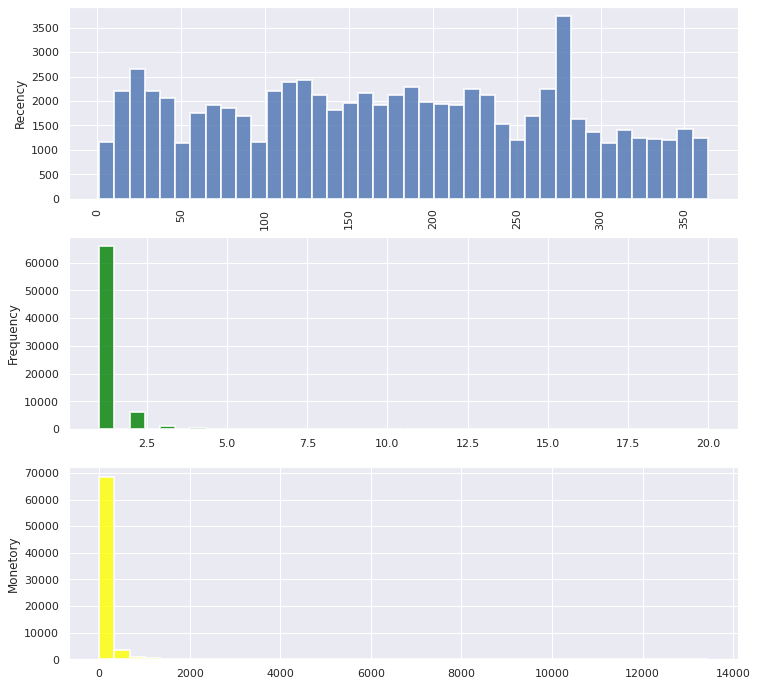

In [185]:
plt.figure(figsize=(12,12))
plt.subplot(311)
data['Recency'].hist(bins=40, alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Recency')
plt.xticks(rotation=90)
plt.subplot(312)
data['Frequency'].hist(bins=40, color = 'green', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Frequency')
plt.subplot(313)
data['Monetory'].hist(bins=40, color = 'yellow', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Monetory')
plt.show()

## Реализуем 2 варианта:
### 1. Квантильный RFM:

In [186]:
def rfm_quantile(rfm_data: pd.DataFrame() = None, metrics: list() = None, q: int = 4):
    if rfm_data is None:
        return None
    if metrics is None:
        metrics = rfm_data.columns[1:]
    Recency, Frequency, Monetary = metrics
    rfm_data[metrics] = rfm_data[metrics].dropna().astype('int64')

    labels = range(q, 0, -1)
    rfm_data['R'] = pd.qcut(rfm_data[Recency], q=q, labels=labels).values
    rfm_data['F'] = rfm_data[Frequency].apply(lambda x : 2 if x==1 else 1) #т.к. у нас очень много 1, qcut плохо справляется 
    rfm_data['M'] = pd.qcut(rfm_data[Monetary], q=q, labels=labels[::-1]).values
    rfm_data['RFM_Segment'] = rfm_data.apply(lambda x: str(x['R']) +
                                                       str(x['F']) +
                                                       str(x['M']), axis=1)
    rfm_data['RFM_Score'] = rfm_data[['R', 'F', 'M']].sum(axis=1)
    return rfm_data

In [187]:
rfm_result = rfm_quantile(data, metrics = ['Recency', 'Frequency', 'Monetory'], q = 4)

In [188]:
rfm_result

,customer_unique_id,Recency,Frequency,Monetory,R,F,M,RFM_Segment,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129,3,2,3,323,8
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18,3,2,1,321,6
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25,1,2,1,121,4
4,0004aac84e0df4da2b147fca70cf8255,289,1,180,1,2,4,124,7
5,0004bd2a26a76fe21f786e4fbd80607f,147,1,154,3,2,4,324,9
...,...,...,...,...,...,...,...,...,...
95572,fffa431dd3fcdefea4b1777d114144f2,304,1,64,1,2,2,122,5
95573,fffb09418989a0dbff854a28163e47c6,256,1,58,2,2,2,222,6
95574,fffbf87b7a1a6fa8b03f081c5f51a201,246,1,149,2,2,3,223,7
95576,fffea47cd6d3cc0a88bd621562a9d061,263,1,64,1,2,2,122,5


In [189]:
rfm_result.describe()

,Recency,Frequency,Monetory,F,RFM_Score
count,73768.000000,73768.000000,73768.000000,73768.000000,73768.000000
mean,174.291942,1.153576,137.778942,1.893274,6.897489
std,99.666577,0.563208,208.127835,0.308767,1.568681
min,1.000000,1.000000,0.000000,1.000000,3.000000
25%,90.000000,1.000000,46.000000,2.000000,6.000000
50%,174.000000,1.000000,88.000000,2.000000,7.000000
75%,262.000000,1.000000,149.000000,2.000000,8.000000
max,364.000000,20.000000,13440.000000,2.000000,10.000000


In [190]:
rfm = rfm_result[['RFM_Score', 'customer_unique_id']].groupby(['RFM_Score']).customer_unique_id.nunique().reset_index().rename({'customer_unique_id': 'users'}, axis = 1)
rfm.head(10)

,RFM_Score,users
0,3,163
1,4,4757
2,5,9990
3,6,14396
4,7,18294
5,8,13278
6,9,8769
7,10,3679


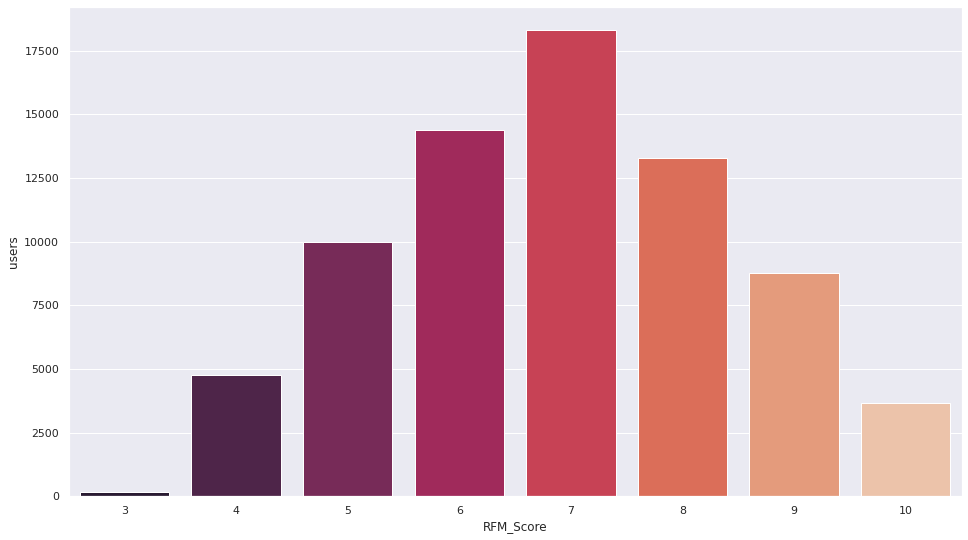

In [191]:
sns.barplot(data = rfm, x = 'RFM_Score', y = 'users', palette = "rocket")

In [192]:
rfm_aggr = rfm_result[['customer_unique_id', 'R', 'F']].groupby(['R', 'F']).customer_unique_id.nunique().reset_index()
rfm_pivot = rfm_aggr.pivot(values = 'customer_unique_id', index='R', columns='F')

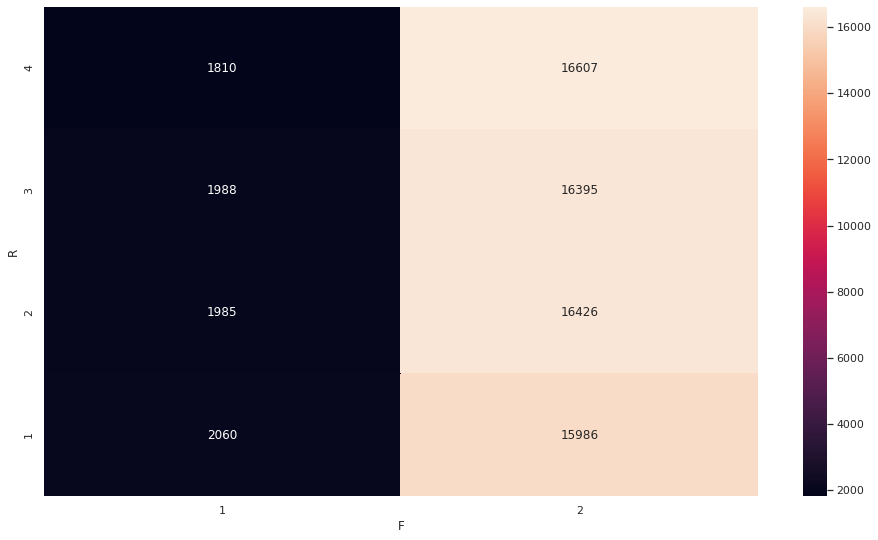

In [194]:
sns.heatmap(rfm_pivot, annot=True, fmt=".0f");

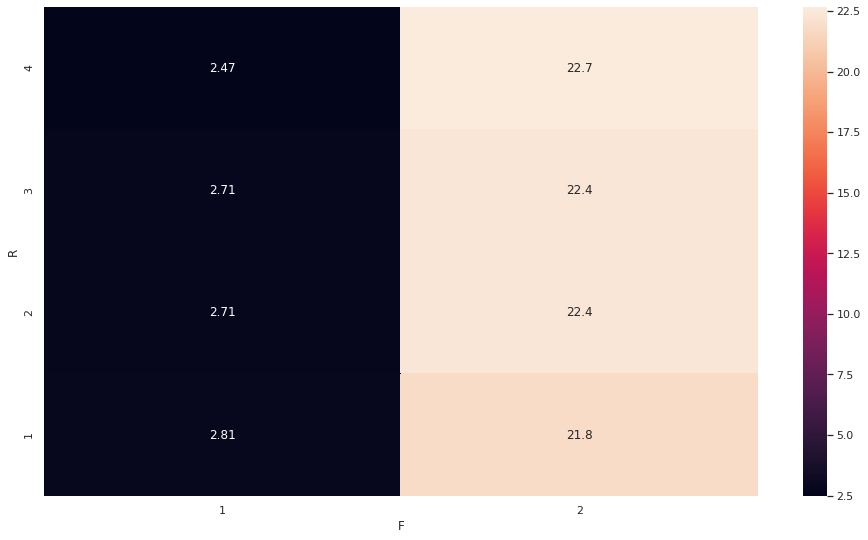

In [195]:
rfm_aggr['users_share'] = rfm_aggr['customer_unique_id']*1.0/rfm_aggr['customer_unique_id'].sum()*100.0
sns.heatmap(rfm_aggr.pivot(values = 'users_share', index='R', columns='F'), annot=True, fmt=".3g");

### 2. RFM при помощи kmeans:

### 2.1. Масштабирование данных:

In [174]:
def scale_data(X_train: pd.DataFrame() = None, 
               metrics: list() = None):
    if X_train is None:
        return None
    if metrics is None:
        metrics = X_train.columns[1:]
    Recency, Frequency, Monetary = metrics  # Syntax Sugar
    X_train_scaled = X_train.copy(deep=True)
    X_train_scaled[metrics[1:]] = X_train_scaled[metrics[1:]].dropna().astype('int64')

    # Conforming to the "Standart C99" `np.log(item)` returns `-Inf` value for item <= 0
    # Therefore we should handle it:
    adjust_to_uno = lambda item: 1 if item <= 0 else item
    X_train_scaled[Recency] = X_train_scaled[Recency].apply(adjust_to_uno)
    X_train_scaled[Monetary] = X_train_scaled[Monetary].apply(adjust_to_uno)
    # Unskew the data by logorithm (https://towardsdatascience.com/transforming-skewed-data-73da4c2d0d16):
    X_train_scaled[metrics] = X_train_scaled[metrics].apply(np.log, axis=1).round(3)
    return X_train_scaled

In [200]:
data_transformed = scale_data(data[['customer_unique_id', 'Recency', 'Frequency', 'Monetory']])

In [201]:
data_transformed

,customer_unique_id,Recency,Frequency,Monetory
0,0000366f3b9a7992bf8c76cfdf3221e2,4.718,0.0,4.860
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.745,0.0,2.890
3,0000f6ccb0745a6a4b88665a16c9f078,5.775,0.0,3.219
4,0004aac84e0df4da2b147fca70cf8255,5.666,0.0,5.193
5,0004bd2a26a76fe21f786e4fbd80607f,4.990,0.0,5.037
...,...,...,...,...
95572,fffa431dd3fcdefea4b1777d114144f2,5.717,0.0,4.159
95573,fffb09418989a0dbff854a28163e47c6,5.545,0.0,4.060
95574,fffbf87b7a1a6fa8b03f081c5f51a201,5.505,0.0,5.004
95576,fffea47cd6d3cc0a88bd621562a9d061,5.572,0.0,4.159


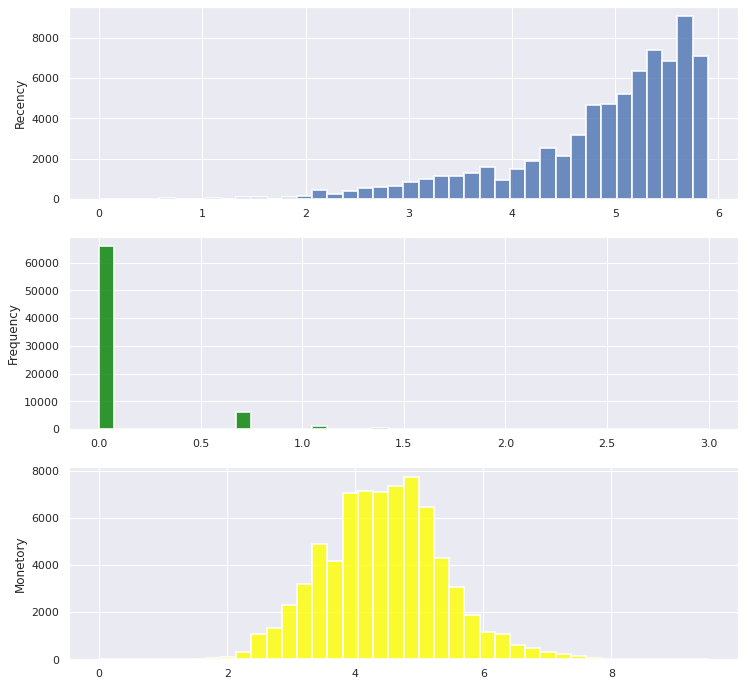

In [205]:
plt.figure(figsize=(12,12))
plt.subplot(311)
data_transformed['Recency'].hist(bins=40, alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Recency')
plt.subplot(312)
data_transformed['Frequency'].hist(bins=40, color = 'green', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Frequency')
plt.subplot(313)
data_transformed['Monetory'].hist(bins=40, color = 'yellow', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Monetory')
plt.show()

### 2.2. Нормализация данных:

In [206]:
def normalize_data(X_train: pd.DataFrame() = None, metrics: list() = None, name: str = ''):
    if X_train is None:
        return None
    if metrics is None:
        metrics = X_train.columns[1:]
    X_train_scaled = X_train.copy(deep=True)
    X_train_scaled[metrics] = X_train_scaled[metrics].astype('int64')

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler() # StandardScaler() # MaxAbsScaler # MinMaxScaler
    pipe = Pipeline([('imputer', imputer), ('scaler', scaler)])

    X_train_scaled[metrics] = pd.DataFrame(data=pipe.fit_transform(X_train_scaled[metrics]),
                                               columns=metrics)
    return X_train_scaled

In [207]:
data_transformed = normalize_data(data_transformed[['customer_unique_id', 'Recency', 'Frequency', 'Monetory']])

In [208]:
data_transformed.describe()

,Recency,Frequency,Monetory
count,56934.000000,56934.000000,56934.000000
mean,0.000206,0.004357,0.001970
std,1.001824,1.013976,0.999001
min,-4.938330,-0.160528,-3.981495
25%,-0.413246,-0.160528,-0.949901
50%,0.718025,-0.160528,0.060631
75%,0.718025,-0.160528,1.071162
max,0.718025,12.110778,5.113288


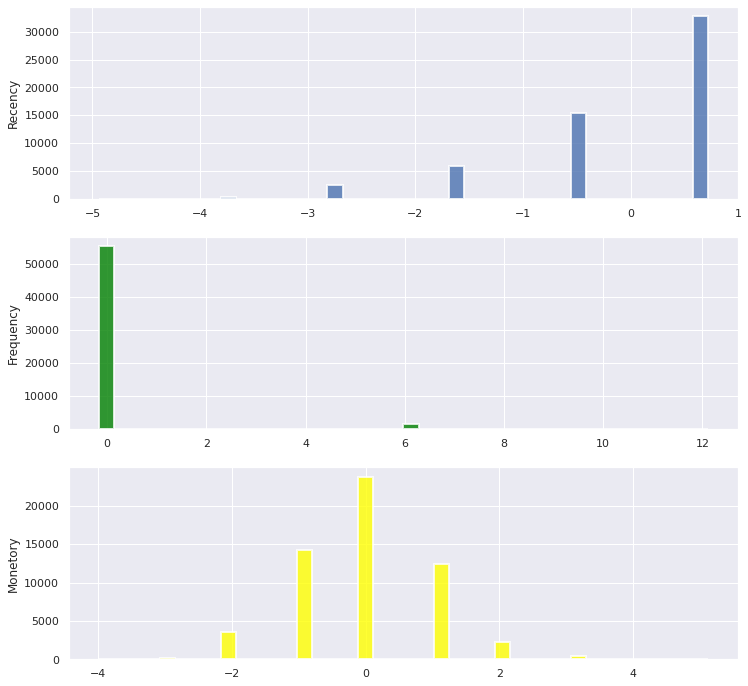

In [209]:
plt.figure(figsize=(12,12))
plt.subplot(311)
data_transformed['Recency'].hist(bins=40, alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Recency')
plt.subplot(312)
data_transformed['Frequency'].hist(bins=40, color = 'green', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Frequency')
plt.subplot(313)
data_transformed['Monetory'].hist(bins=40, color = 'yellow', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Monetory')
plt.show()

### 2.3. Определение количества кластеров

In [210]:
def wcss(rfm_data: pd.DataFrame() = None, metrics: list() = None):
    if rfm_data is None:
        return None
    if metrics is None:
        metrics = rfm_data.columns

    wcss = {}
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300)
        kmeans.fit(rfm_data)
        wcss[k] = kmeans.inertia_
    # plot the WCSS values
    sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
    plt.xlabel('K Numbers')
    plt.ylabel('WCSS')
    plt.show()
    return

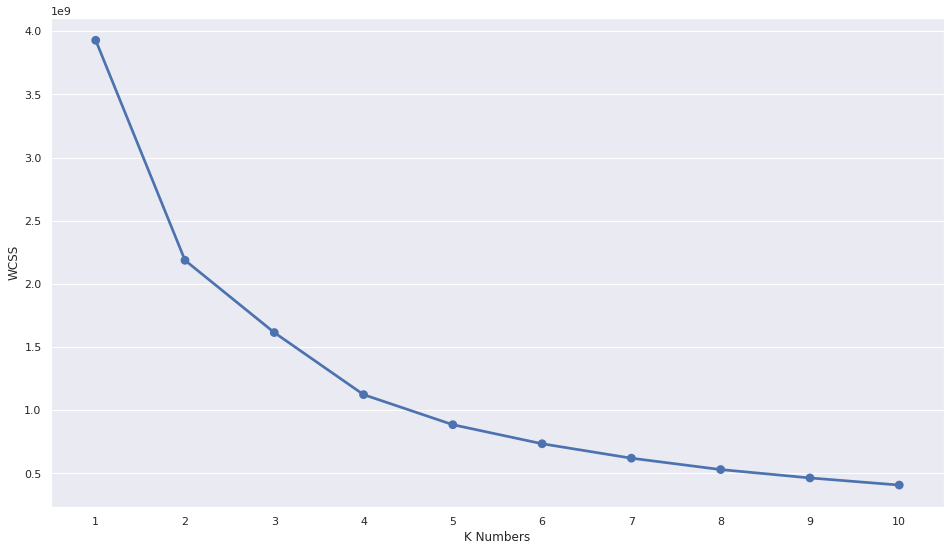

In [211]:
wcss(data[['Recency', 'Frequency', 'Monetory']])

### 2.4. Сегментация при помощи K-Means:

In [218]:
def rfm_knn(rfm_data: pd.DataFrame() = None, metrics: list() = None, name: str = '', n_clusters: int = 4):
    if rfm_data is None:
        return None
    if metrics is None:
        metrics = rfm_data.columns[1:]
    # Сlustering
    Recency, Frequency, Monetary = metrics

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[[Recency]].dropna().astype('int64'))
    rfm_data['R_Cluster'] = kmeans_clusters.labels_+1

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[[Frequency]].dropna().astype('int64'))
    rfm_data['F_Cluster'] = kmeans_clusters.labels_+1

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[[Monetary]].dropna().astype('int64'))
    rfm_data['M_Cluster'] = kmeans_clusters.labels_+1

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[metrics].dropna().astype('int64'))
    # Assign the clusters to datamart
    rfm_data['K_Cluster'] = kmeans_clusters.labels_+1
    return rfm_data

In [220]:
result = rfm_knn(data[['customer_unique_id', 'Recency', 'Frequency', 'Monetory']])

In [223]:
rfm_aggr = result[['customer_unique_id', 'R_Cluster', 'F_Cluster']].groupby(['R_Cluster', 'F_Cluster']).customer_unique_id.nunique().reset_index()
rfm_pivot = rfm_aggr.pivot(values = 'customer_unique_id', index='R_Cluster', columns='F_Cluster')

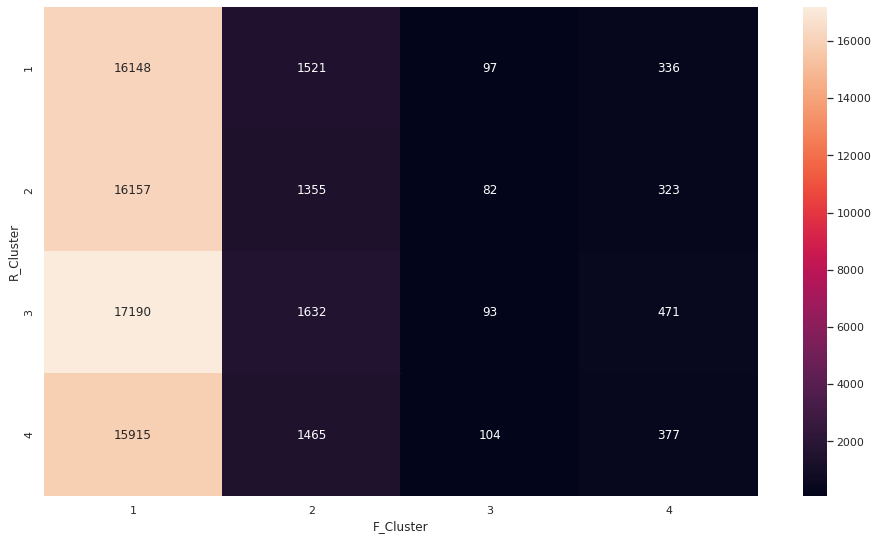

In [224]:
sns.heatmap(rfm_pivot, annot=True, fmt=".0f")

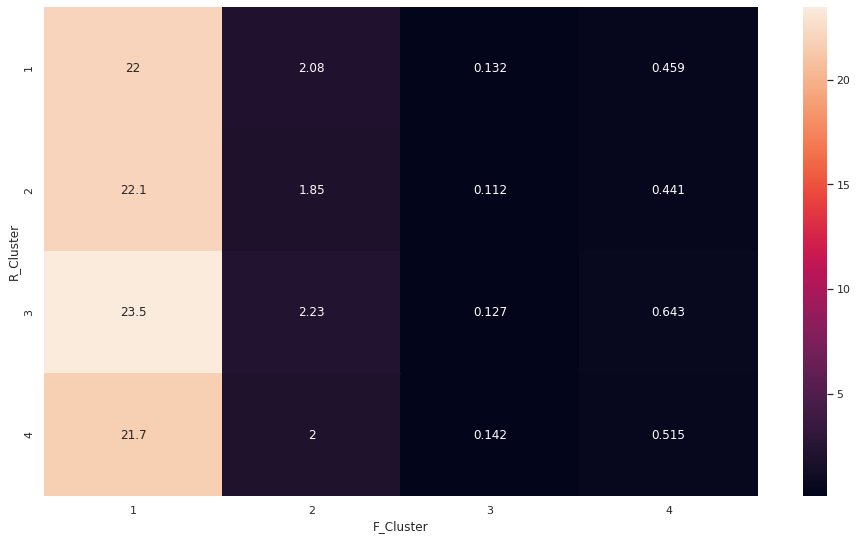

In [226]:
rfm_aggr['users_share'] = rfm_aggr['customer_unique_id']*1.0/rfm_aggr['customer_unique_id'].sum()*100.0
sns.heatmap(rfm_aggr.pivot(values = 'users_share', index='R_Cluster', columns='F_Cluster'), annot=True, fmt=".3g")

Ответ по шаблону из задания:

In [227]:
data

,customer_unique_id,Recency,Frequency,Monetory,R,F,M,RFM_Segment,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129,3,2,3,323,8
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18,3,2,1,321,6
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25,1,2,1,121,4
4,0004aac84e0df4da2b147fca70cf8255,289,1,180,1,2,4,124,7
5,0004bd2a26a76fe21f786e4fbd80607f,147,1,154,3,2,4,324,9
...,...,...,...,...,...,...,...,...,...
95572,fffa431dd3fcdefea4b1777d114144f2,304,1,64,1,2,2,122,5
95573,fffb09418989a0dbff854a28163e47c6,256,1,58,2,2,2,222,6
95574,fffbf87b7a1a6fa8b03f081c5f51a201,246,1,149,2,2,3,223,7
95576,fffea47cd6d3cc0a88bd621562a9d061,263,1,64,1,2,2,122,5


In [275]:
RFM = sorted(list(set(data.RFM_Segment.to_list())))
RFM

['111',
 '112',
 '113',
 '114',
 '121',
 '122',
 '123',
 '124',
 '211',
 '212',
 '213',
 '214',
 '221',
 '222',
 '223',
 '224',
 '311',
 '312',
 '313',
 '314',
 '321',
 '322',
 '323',
 '324',
 '411',
 '412',
 '413',
 '414',
 '421',
 '422',
 '423',
 '424']

In [276]:
RFM_df = pd.DataFrame({'RFM':RFM})

In [277]:
RFM_df['R'] = RFM_df.RFM.apply(lambda x : str(x)[0])
RFM_df['F'] = RFM_df.RFM.apply(lambda x : str(x)[1])
RFM_df['M'] = RFM_df.RFM.apply(lambda x : str(x)[2])

Разделим данные 

In [278]:
data[['Recency', 'Frequency', 'Monetory']].quantile([.25, .5, .75, .90]).to_dict()

{'Recency': {0.25: 90.0, 0.5: 174.0, 0.75: 262.0, 0.9: 312.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0, 0.9: 2.0},
 'Monetory': {0.25: 46.0, 0.5: 88.0, 0.75: 149.0, 0.9: 269.0}}

In [279]:
pd.qcut(data['Monetory'], q=4)

0           (88.0, 149.0]
1          (-0.001, 46.0]
3          (-0.001, 46.0]
4        (149.0, 13440.0]
5        (149.0, 13440.0]
               ...       
95572        (46.0, 88.0]
95573        (46.0, 88.0]
95574       (88.0, 149.0]
95576        (46.0, 88.0]
95578       (88.0, 149.0]
Name: Monetory, Length: 73768, dtype: category
Categories (4, interval[float64]): [(-0.001, 46.0] < (46.0, 88.0] < (88.0, 149.0] < (149.0, 13440.0]]

In [280]:
Recency = {'1':'от 0 до 3 мес.',
           '2':'от 3 до 6 мес.',
           '3':'от 6 до 9 мес.',
           '4':'от 9 до 12 мес.'}

In [281]:
Frequency = {'1':'>1 покупки',
             '2':'1 покупка'}

In [282]:
Monetory = {'4':'до 46 долларов',
            '3':'от 46 долларов до 88 долларов',
            '2':'от 88 долларов до 149 долларов',
            '1':'от 149 долларов'}

In [283]:
RFM_df['R'] = RFM_df['R'].apply(lambda x : Recency[x])

In [284]:
RFM_df['F'] = RFM_df['F'].apply(lambda x : Frequency[x])

In [285]:
RFM_df['M'] = RFM_df['M'].apply(lambda x : Monetory[x])

In [286]:
RFM_df

,RFM,R,F,M
0,111,от 0 до 3 мес.,>1 покупки,от 149 долларов
1,112,от 0 до 3 мес.,>1 покупки,от 88 долларов до 149 долларов
2,113,от 0 до 3 мес.,>1 покупки,от 46 долларов до 88 долларов
3,114,от 0 до 3 мес.,>1 покупки,до 46 долларов
4,121,от 0 до 3 мес.,1 покупка,от 149 долларов
5,122,от 0 до 3 мес.,1 покупка,от 88 долларов до 149 долларов
6,123,от 0 до 3 мес.,1 покупка,от 46 долларов до 88 долларов
7,124,от 0 до 3 мес.,1 покупка,до 46 долларов
8,211,от 3 до 6 мес.,>1 покупки,от 149 долларов
9,212,от 3 до 6 мес.,>1 покупки,от 88 долларов до 149 долларов
